<a href="https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/numerical-calculus-integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Calculus. Integration
<a href="https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/numerical-calculus-integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Throughout this section and the next ones, we shall cover the topic of numerical calculus. Calculus has been identified since ancient times as a powerful toolkit for analysing and handling geometrical problems. Since differential calculus was developed by Newton and Leibniz (in its actual notation), many different applications have been found, at the point that most of the current science is founded on it (e.g. differential and integral equations). Due to the ever increasing complexity of analytical expressions used in physics and astronomy, their usage becomes more and more impractical, and numerical approaches are more than necessary when one wants to go deeper. This issue has been identified since long ago and many numerical techniques have been developed. We shall cover only the most basic schemes, but also providing a basis for more formal approaches.

From [7 (Chapter 18)](http://pages.cs.wisc.edu/~amos/412/lecture-notes/lecture18.pdf)
> We can only find anti-derivatives for a very small number of functions, such as those functions that are popular as problems in mathematics textbooks. Outside of math classes, these functions are rare 


- - -
- [Numerical Differentiation](./numerical-calculus.ipynb) 
- [Numerical Integration](#Numerical-Integration)
    - [Numerical quadrature](#Numerical-quadrature)
    - [Trapezoidal rule](#Trapezoidal-rule)
    - [Simpson's rule](#Simpson's-rule)
- [Composite Numerical Integration](#Composite-Numerical-Integration)
    - [Composite trapezoidal rule](#Composite-trapezoidal-rule)
    - [Composite Simpson's rule](#Composite-Simpson's-rule)
- [Adaptive Quadrature Methods](#Adaptive-Quadrature-Methods)
    - [Simpson's adaptive quadrature](#Simpson's-adaptive-quadrature)
    - [Steps Simpson's adaptive quadrature](#Steps-Simpson's-adaptive-quadrature)
- [Improper Integrals](#Improper-Integrals)
    - [Left endpoint singularity](#Left-endpoint-singularity)
    - [Right endpoint singularity](#Right-endpoint-singularity)
    - [Infinite singularity](#Infinite-singularity)
    
- - -

## Bibliograpy
* https://github.com/restrepo/Calculus
* Thomas J. Sargent John Stachurski, [Python Programming for Quantitative Economics GitHub](https://python-programming.quantecon.org/scipy.html)

In [26]:
%pylab inline
import numpy as np
import scipy.interpolate as interpolate
import scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Numerical Integration

Integration is the second fundamental concept of calculus (along with differentiation). Numerical approaches are generally more useful here than in differentiation as the antiderivative procedure (analytically) is often much more complex, or even not possible. In this section we will cover some basic schemes, including numerical quadratures.

Geometrically, integration can be understood as the area below a funtion within a given interval. Formally, given a function $f(x)$ such that $f\in C^{1}[a,b]$, the antiderivative is defined as

$$F(x) = \int f(x) dx$$

valid for all $x$ in $[a,b]$. However, a more useful expression is a definite integral, where the antiderivative is evaluated within some interval, i.e.

$$F(b) - F(a) = \int_{a}^{b} f(x) dx$$

This procedure can be formally thought as a generalization of discrete weighted summation. This idea will be exploited below and will lead us to some first approximations to integration.

See pag. 66 of [PDF](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZmlzaWNhLnVkZWEuZWR1LmNvfGNvbXB1dGFkb3Jlcy1lbi1maXNpY2EtMjAxMC0yfGd4OjFmMDJjN2NlOTc3YWE0YTQ)


## Numpy abstractions
The programming paradigm with Numpy are the abstractions, where the algorithms are written in terms of operations with arrays, avoiding the use of  programming loops. Low level operations between arrays are implemented in C/Fortran within Numpy. Therefore, a code with abstractions is automatically optimized.

Consider for example the numerical integration with the trapezoidal method

![Credit Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Integration_rectangle.svg/300px-Integration_rectangle.svg.png) <small>[See Wikipedia](https://en.wikipedia.org/wiki/Numerical_integration#Methods_for_one-dimensional_integrals)</small>

Wehere for each internval between $x_i$ and $x_{i+1}$, the average height of the function 
$$\frac{f(x_i)+f(x_{i-1})}{2}\,,$$
is used. Therefore
\begin{align*}
  \int_a^b f(x)\operatorname{d} x\approx \frac{1}{2}\sum_{i=1}^n (x_i-x_{i-1})(f(x_i)+f(x_{i-1}))\,.
\end{align*}

To implement the correspponding abstractions in Numpy it is convenient to define the following vectors
$$\mathbf{X}_{\text{inc}}=(x_1,x_2,\cdots,x_n)$$
$$\mathbf{X}_{\text{not inc}}=(x_0,x_1,\cdots,x_{n-1})$$
\begin{align*}
  \Delta \mathbf{X}=\mathbf{X}_{\text{inc}}-\mathbf{X}_{\text{not inc}}&=(x_1-x_0,x_2-x_1,\cdots,x_n-x_{n-1})\\ 
   \langle\mathbf{f}\rangle=\frac{\mathbf{f}_{\text{inc}}(x)+\mathbf{f}_{\text{not inc}}(x)}{2} =&\frac{1}{2}(f(x_1)+f(x_0),f(x_2)+f(x_1),\cdots,f(x_n)+f(x_{n-1}))\,.
\end{align*}
The numerical approximation of the integral with the trapezoidal method is then just the dot product between the two previous vectors
\begin{align*}
   \int_a^b f(x)d x\approx \Delta \mathbf{X}\cdot \langle\mathbf{f}\rangle
\end{align*}

We next present the code with different levels of abstractions. The faster is the first one with the direct implementation of the dot product.

Example:

In [5]:
x=np.linspace(1,2,5)
x

array([1.  , 1.25, 1.5 , 1.75, 2.  ])

In [9]:
f=lambda x:x
y=f(x)
y

array([1.  , 1.25, 1.5 , 1.75, 2.  ])

In [6]:
# Increased points
x[1:]

array([1.25, 1.5 , 1.75, 2.  ])

In [7]:
# Not increased points
x[:-1]

array([1.  , 1.25, 1.5 , 1.75])

In [14]:
x[1:]-x[:-1]

array([0.25, 0.25, 0.25, 0.25])

In [15]:
0.5*(y[1:]+y[:-1])

array([1.125, 1.375, 1.625, 1.875])

In [10]:
np.dot((x[1:]-x[:-1]),(y[1:]+y[:-1]))

3.0

In [11]:
(x[1:]-x[:-1])@(y[1:]+y[:-1])

3.0

In [12]:
(x[1:]-x[:-1])*(y[1:]+y[:-1])

array([0.5625, 0.6875, 0.8125, 0.9375])

In [16]:
(x[1:]-x[:-1])*(y[1:]+y[:-1]).sum()

array([3., 3., 3., 3.])

In [18]:
import numpy as np
def integracion(f,a,b,n=4,test=0):
    '''Trapezoidal method for the numerical integration  de f entre a y b
         con n intervalos
    '''
    x=np.linspace(a,b,n+1)
    y=f(x)
    if test == 0:
        return 0.5*(x[1:]-x[:-1])@(y[1:]+y[:-1])
    elif test ==1:
        return 0.5*((x[1:]-x[:-1])*(y[1:]+y[:-1])).sum()

$$\int_1^2 x\,\operatorname{d}x$$

In [23]:
integracion(lambda x:x,1,2,n=100),integracion(lambda x:x,1,2,n=100,test=1)

(1.4999999999999996, 1.4999999999999996)

$$\int_1^2 x\,\operatorname{d}x=\left.\frac{x^2}{2}\right|_1^2=\frac{2^2}{2}-\frac{1^2}{2}=2-\frac{1}{2}=\frac{3}{2}=1.5$$

## Implementation in scipy

```python
integrate.quad(func,a,b,args=(),full_output=0,...)
```
__Parameters__:
```python
```

    

See `integrate.quad?` for further details

###  Usage example

In [28]:
f= lambda x: np.sin ( x )/ x

Note that:

In [25]:
f(0)

/tmp/ipykernel_447648/1993316095.py:1: RuntimeWarning: invalid value encountered in double_scalars
  f= lambda x: np.sin ( x )/ x


nan

Even so, the full tuple output with result and numerical error is obtained from

In [40]:
integrate.quad(f,0,1)#,epsrel=1E-3)

(0.9460830703671831, 1.0503632079297089e-14)

In [30]:
integrate.quad(f,0,1)[0]

0.9460830703671831

In [31]:
import time

Unix time in seconds

In [32]:
time.time()/3600/24/365

52.141734441856336

In [46]:
s=time.time()
print(integrate.quad(f,0,1))
print(time.time()-s)

(0.9460830703671831, 1.0503632079297089e-14)
0.0010361671447753906


In [47]:
%%timeit
integrate.quad(f,0,1)

35 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
0.00000425#[s]

4.25e-06

Force output to have only the result by asking for the entry 0 of the output tuple, note the `[0]` at the end:

In [49]:
integrate.quad(lambda x: np.sin ( x )/x,0,1)

(0.9460830703671831, 1.0503632079297089e-14)

Avoid singularities in custom solutions 

In [51]:
integracion(lambda x: np.sin ( x )/x,1E-16,1,n=5)

0.9450787809534019

Sinintegrate: 
$$\operatorname{Si}(t)=\int_0^t \frac{\sin x}{x}\, \operatorname{d}x$$

$sin x $ → `s*i*n*x`

$$\sin x$$
$$\operatorname{sin}x$$

En un texto científico las operaciones matemáticas se deben diferencia del texto normal, por ejemplo, yo puedo decir abc de abcedario, pero si digo $abc$ eso quiere decir `a*b*c`. Por eso hay que usar modo matématico incluso para referirse a la variable $a$ que es diferenta a la letra a

$$x\,x\;x\ x\quad x\qquad x$$

In [63]:
import numbers

In [61]:
type(np.array([2])[0])

numpy.int64

In [70]:
x=np.array([2.])[0]
isinstance(x,numbers.Real)

True

In [79]:
import numbers
import numpy as np
import scipy.integrate as integrate

Sifloat=lambda t: integrate.quad(lambda x:np.sin(x)/x,0,t)[0]
def Si(t):
    '''
    Sinintegrate
    '''
    if isinstance(t,numbers.Real):
        f=Sifloat
    else:
        f=np.vectorize(Sifloat)
    return f(t)

In [80]:
Si(1.)

0.9460830703671831

In [75]:
Si([1,2])

array([0.94608307, 1.60541298])

When you write `LaTeX`  in  `matplotlib`, you must be sure that the backslash, '\', is properly interpreted  as the key for `LaTeX` commands. This is accomplished  by writting an `r` before the string declaration. Note the different behaviour of the backslash in the next two cells of code. In the first one `\t` is intepreted as the keyboard key `<TAB>` and `\b` as an empty space, while in the second, with the prefix `r`, it is just a pair of `LaTeX` commands

In [34]:
print('this is tab begin:\tend. And a new line\nStar here.')

this is tab begin:	end. And a new line
Star here.


In [35]:
print('$\tan\beta$')

$	aeta$


In [36]:
print(r'$\tan\beta$')

$\tan\beta$


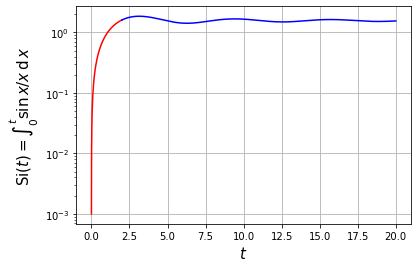

In [81]:
t=np.logspace(np.log10(1E-3),np.log10(2),200) #(-3,0.301,200)
tt=np.linspace(2,20,200)
plt.semilogy(t,Si(t),'r-')
plt.semilogy(tt,Si(tt),'b-')
plt.xlabel(r'$t$',size=15)
plt.ylabel(r'${\rm Si}(t)=\int_0^t {\sin x}/{x}\,{\rm d}\,x$',size=15)
plt.grid()

## <span style="color:red">   Activity </span>

### Models of Universe

From the Friedmann equations can be found the dynamics of the Universe, i.e., the evolution of the expansion with time that depends on the content of matter and energy of the Universe. Before introducing the general expression, there are several quatities that need to be defined. 

It is convenient to express the density in terms of a critical density $\rho_c$ given by

\begin{equation}
\rho_c = 3H_0^2/8\pi G
\end{equation}

where $H_o$ is the Hubble constant. The critical density is the density needed in order the Universe to be flat. To obtained it, it is neccesary to make the curvature of the universe $\kappa = 0$. The critical density is one value per
time and the geometry of the universe depends on this value, or equally on $\kappa$. For a universe with $\kappa<0$ it would ocurre a big crunch(closed universe) and for a $\kappa>0$ there would be an open universe.    

Now, it can also be defined a density parameter, $\Omega$, a normalized density

\begin{equation}
\Omega_{i,0} = \rho_{i,0}/\rho_{crit}
\end{equation}

where $\rho_{i,0}$ is the actual density($z=0$) for the component $i$. Then, it can be found the next expression 

\begin{equation}
\frac{H^2(t)}{H_{0}^{2}} = (1-\Omega_0)(1+z)^2 + \Omega_{m,0}(1+z^3)+ \Omega_{r,0}(1+z)^4 + \Omega_{\Lambda,0}
\end{equation}

where $\Omega_{m,0}$, $\Omega_{r,0}$ and  $\Omega_{\Lambda,0}$ are the matter, radiation and vacuum density parameters. And $\Omega_0$ is the total density including the vacuum energy. 

This expression can also be written in terms of the expansion or scale factor, $a$, by using: 

$$1+z = 1/a$$

For the next universe models, plot time($H_{0}^{-1}$ units) vs the scale factor:

-Einstein-de Sitter Universe: Flat space, null vacuum energy and dominated by matter

\begin{equation}
t = H_0^{-1} \int_0^{a'} a^{1/2}da
\end{equation}
 
-Radiation dominated universe: All other components are not contributing 

$$
t = H_0^{-1} \int_0^{a'} \frac{a}{[\Omega_{r,0}+a^2(1-\Omega_{r,0})]^{1/2}}da
$$

-WMAP9 Universe 

\begin{equation}
t = H_0^{-1} \int_0^{a'} \left[(1-\Omega_{0})+ \Omega_{M,0}a^{-1} + \Omega_{R,0}a^{-2} +\Omega_{\Lambda,0}a^2\right]^{-1/2} da
\end{equation}


You can take the cosmological parameters  from the link 

http://lambda.gsfc.nasa.gov/product/map/dr5/params/lcdm_wmap9.cfm or use these ones: $\Omega_M = 0.266$,
$\Omega_R = 8.24\times 10^{-5}$ and $\Omega_\Lambda = 0.734$. 

Use composite Simpson's rule to integrate and compare it with the analytical expression in case you can get it. 
The superior limit in the integral corresponds to the actual redshift $z=0$. What is happening to our universe? 


## <span style='color:red'>  Activity </span>

- Using the Simpson's adaptive quadrature determine the value of the next integral with a precision of float32.

$$\int_0^4 e^{-3x}\sin(4x)dx$$


## <span style='color:red'>  Activity </span>
Fresnel integrals are commonly used in the study of light difraction at a rectangular aperture, they are given by:

$$c(t) = \int_0^t\cos\left(\frac{\pi}{2}\omega^2\right)d\omega$$

$$s(t) = \int_0^t\sin\left(\frac{\pi}{2}\omega^2\right)d\omega$$

These integrals cannot be solved using analitical methods. Using the previous routine for adaptive quadrature, compute the integrals with a precision of $\epsilon=10^{-4}$ for values of $t=0.1,0.2,0.3,\cdots 1.0$. Create two arrays with those values and then make a plot of $c(t)$ vs $s(t)$. The resulting figure is called Euler spiral, that is a member of a family of curves called [Clothoid loops](http://en.wikipedia.org/wiki/Vertical_loop).


- - -

# Improper Integrals

Improper integral can be processed with the `quad` function of `scipy.integrate`, or other integration functions, by using the infinity implementation of `numpy`, (which is the same of the `math` module, see below)
* Positive infinity ($+\infty$): `np.inf` and several aliases
* Negagite infinity ($-\infty$): `np.NINF`
For details of the implementation and the aliases [see here](https://stackoverflow.com/a/42315752/2268280)

In [1]:
import numpy as np

In Python the $\infty$ can be defined as

In [4]:
float('infinity')

inf

In [76]:
float('inf')

inf

It is already implemented in numpy

In [5]:
np.inf == float('inf')

True

In [6]:
24343555355567<np.inf

True

There are also function to check for infinity numbers:

In [7]:
np.isfinite(2)

True

In [8]:
np.isfinite(np.inf)

False

In [9]:
np.isfinite(2),np.isinf(np.inf)

(True, True)

In [11]:
from scipy import integrate

So it is possible to evaluate improper integrals like

$$
\int_1^\infty x^{-2}\,\operatorname{d}x=1\,.
$$

In [12]:
integrate.quad(lambda x: 1/x**2,1,np.inf)

(1.0, 1.1102230246251565e-14)

or
$$
\int_{-\infty}^\infty \operatorname{e}^{x^{-2}}\,\operatorname{d}x=\sqrt{\pi},.
$$

https://www.reddit.com/r/mathmemes/comments/snleob/the_gaussian_integral/

In [16]:
integrate.quad(lambda x: np.exp(-x**2),-np.inf,np.inf)[0]==np.sqrt(np.pi)

True

In [14]:
integrate.quad(lambda x: np.exp(-x**2),np.NINF,np.inf)[0]==np.sqrt(np.pi)

True

In [17]:
integrate.quad(lambda x: np.exp(-x**2),0,np.inf)[0]==np.sqrt(np.pi)/2

True

Although the previous integration methods can be applied in almost every situation, improper integrals pose a challenger to numerical methods as they involve indeterminations and infinite intervals. Next, we shall cover some tricks to rewrite improper integrals in terms of simple ones. See for example [here](https://stackoverflow.com/q/30769913/2268280)

## Left endpoint singularity

Assuming a function $f(x)$ such that it can be rewritten as

$$ f(x) = \frac{g(x)}{(x-a)^p} $$

the integral over an interval $[a,b]$ converges only and only if $0<p<1$.

Using Simpson's composite rule, it is possible to compute the fourth-order Taylor polynomial of the function $g(x)$ at the point $a$, obtaining

$$ P_4(x) = g(a) + g^{'}(a)(x-a)+\frac{g^{''}(a)}{2!}(x-a)^2 +\frac{g^{''}(a)}{3!}(x-a)^3+ \frac{g^{(4)}(a)}{4!}(x-a)^4$$

The integral can be then calculated as

$$\int_a^b f(x)dx = \int_a^b\frac{g(x)-P_4(x)}{(x-a)^p}dx + \int_a^b\frac{P_4(x)}{(x-a)^p}dx$$

The second term is an integral of a polynomimal, which can be easily integrated using analytical methods.

The first term is no longer pathologic as there is not any indetermination, and it can be determined using composite Simpson's rule

## Right endpoint singularity

This is the contrary case, where the indetermination is present in the extreme $b$ of the integration interval $[a,b]$. For this problem is enough to make a variable substitution

$$ z=-x \  \ \ \ \ \  dz=-dx$$

With this, the right endpoint singularity becomes a left endpoint singularity and the previous method can be directly applied.

## Infinite singularity

Finally, infinite singularities are those where the integration domain is infinite, i.e.

$$\int_a^\infty f(x)dx$$

this type of integrals can be easily turned into a left endpoint singularity jus making the next variable substitution

$$t = x^{-1}\ \ \ \ \ dt = -x^{-2}dx$$

yielding

$$ \int_a^\infty f(x)dx = \int_0^{1/a}t^{-2}f\left(\frac{1}{t}\right)dt $$

## <span style='color:red'> Activity</span>

Error function is a special and non-elementary function that is widely used in probability, statistics and diffussion processes.
It is defined through the integral:

$$\mbox{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2}dt$$

Using the substitution $u=t^2$ it is possible to use the previous methods for impropers integrals in order to evaluate the error function. Create a routine called `ErrorFunction` that, given a value of $x$, return the respective value of the integral.


- - -